In [2]:
import pandas as pd
import numpy as np
import seaborn as sns


In [35]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [36]:
train.head(2)

,uid,install_timestamp,free_trial_timestamp,country,language,device_type,os_version,attribution_network,product_price_tier,product_periodicity,product_free_trial_length,onboarding_birth_year,onboarding_gender,net_purchases_15d,net_purchases_1y
0,wBmGYN3Z+l3OBvdnzv/fdw==,2019-06-07 00:01:44+00:00,2019-06-07 03:12:33+00:00,US,en,iPhone 6,12.2,Snapchat Installs,20,30,7,2005.0,M,0.0,0.0
1,s8j5KRaEXICNrKRsaBB8FQ==,2019-06-07 00:05:10+00:00,2019-06-08 07:39:48+00:00,US,en,iPhone X,12.3.1,Organic,6,7,7,2000.0,M,4.2,63.0


In [37]:
train.shape, train.dropna().shape # there are some missing data, let's see where

((13370, 15), (13040, 15))

In [38]:
train.isnull().sum()

uid                            0
install_timestamp              0
free_trial_timestamp           6
country                        2
language                       0
device_type                    0
os_version                     0
attribution_network           76
product_price_tier             0
product_periodicity            0
product_free_trial_length      0
onboarding_birth_year        251
onboarding_gender            251
net_purchases_15d              0
net_purchases_1y               0
dtype: int64

In [39]:
train.describe() 
# the free trial length has no variability, can be removed
# we can clearly see that there are wrong data in onboarding_birth_year, a data cleaning step is needed
# the distribution of net_purchases_15d and net_purchases_1y are right-skewed, I will try some transformation to check if this helps in prediction phase

,product_price_tier,product_periodicity,product_free_trial_length,onboarding_birth_year,net_purchases_15d,net_purchases_1y
count,13370.000000,13370.000000,13370.0,13119.000000,13370.000000,13370.000000
mean,20.992820,48.811369,7.0,1993.429606,2.161191,7.014911
std,11.087428,82.858099,0.0,14.970466,3.784696,15.907462
min,6.000000,7.000000,7.0,1900.000000,0.000000,0.000000
25%,20.000000,30.000000,7.0,1989.000000,0.000000,0.000000
50%,20.000000,30.000000,7.0,1996.000000,0.000000,0.000000
75%,20.000000,30.000000,7.0,2000.000000,6.630000,7.000000
max,60.000000,365.000000,7.0,2557.000000,22.210000,116.199997


In [40]:
train.pop('product_free_trial_length')

0        7
1        7
2        7
3        7
4        7
        ..
13365    7
13366    7
13367    7
13368    7
13369    7
Name: product_free_trial_length, Length: 13370, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='net_purchases_1y', ylabel='Density'>

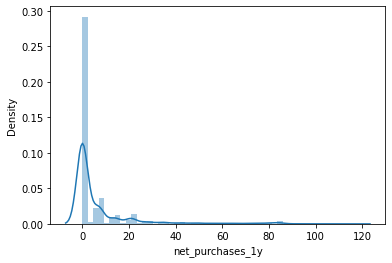

In [41]:
# let's see net_purchases_1y distribution

sns.distplot(train['net_purchases_1y'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='net_purchases_1y', ylabel='Density'>

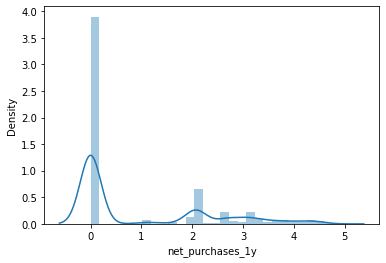

In [42]:
net1y_log = np.log(train['net_purchases_1y'] + 1) # the log transformation seems to make the distribution less skewed (expecialy if one take a look at net_purchases_1y>0), I will check if this helps in prediction later on
sns.distplot(net1y_log)

In [43]:
from scipy.special import boxcox, inv_boxcox #let's check other transformations
data = boxcox(train['net_purchases_1y']+1, 0.5)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8ab9a97880>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8ab9a2e310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8ab9a24b80>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8ab9a2e8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8ab9a2eb80>],
 'means': []}

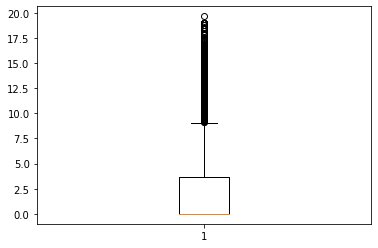

In [44]:
import matplotlib.pyplot as plt
plt.boxplot(data)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='net_purchases_1y', ylabel='Density'>

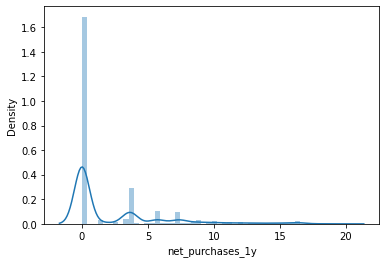

In [45]:
sns.distplot(data)

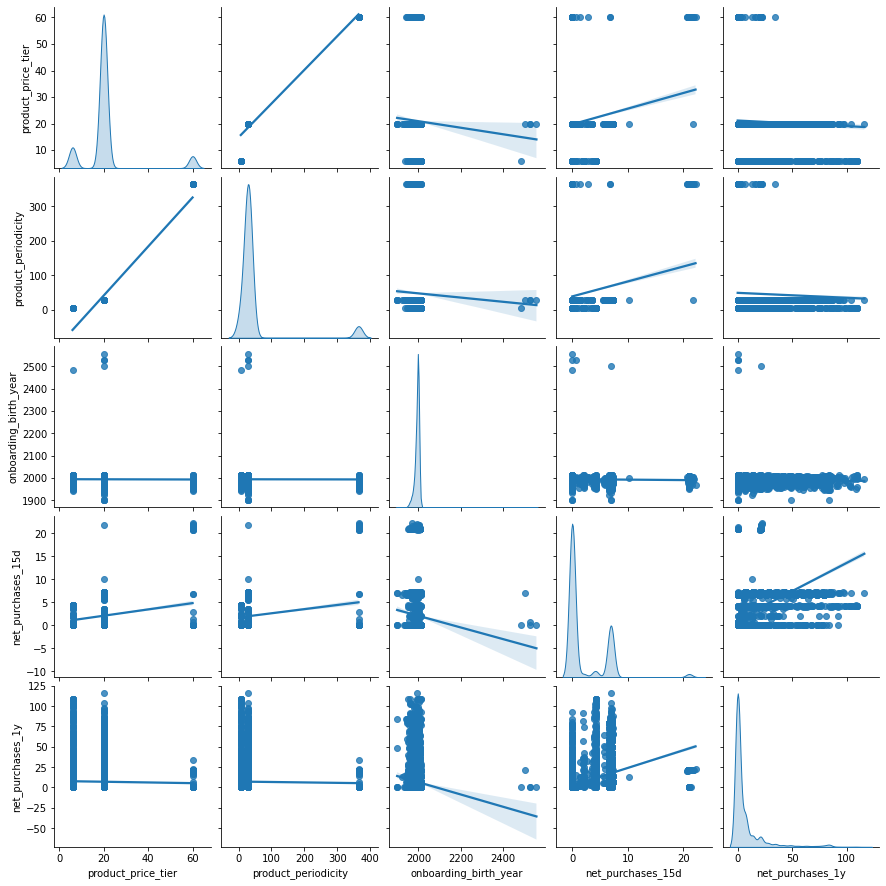

In [46]:
sns.pairplot(train,  kind="reg", diag_kind = "kde")
# there is no feature strongly correlated with net_purchases_1y except from net_purchases_15d


<AxesSubplot:>

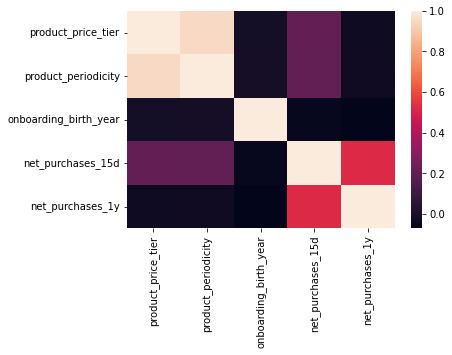

In [47]:
traincorr = train.corr()
sns.heatmap(traincorr) # the low correlation of 1y net purchases with other features is confirmed

In [48]:
test.head(2)

,uid,install_timestamp,free_trial_timestamp,country,language,device_type,os_version,attribution_network,product_price_tier,product_periodicity,product_free_trial_length,onboarding_birth_year,onboarding_gender,net_purchases_15d
0,oZM0Urdhm8tR1ZYKnyGbYw==,2019-06-07 00:11:25+00:00,2019-06-07 00:12:35+00:00,GB,en,iPhone 7,12.2,Organic,6,7,7,1989.0,M,0.0
1,0VzRx4ggiIhf66/Rx8b16Q==,2019-06-07 00:18:03+00:00,2019-06-07 00:22:42+00:00,FR,fr,iPhone 8 Plus,12.3.1,Snapchat Installs,20,30,7,1999.0,M,0.0


In [49]:
test.shape

(3342, 14)

In [50]:
test.isnull().sum() # missing values are in the same column as in train

uid                           0
install_timestamp             0
free_trial_timestamp          1
country                       1
language                      0
device_type                   0
os_version                    0
attribution_network          15
product_price_tier            0
product_periodicity           0
product_free_trial_length     0
onboarding_birth_year        63
onboarding_gender            63
net_purchases_15d             0
dtype: int64

In [51]:
test.describe() # distribution seems similar to train

,product_price_tier,product_periodicity,product_free_trial_length,onboarding_birth_year,net_purchases_15d
count,3342.000000,3342.000000,3342.0,3279.000000,3342.000000
mean,21.263914,50.850688,7.0,1993.262275,2.166062
std,11.460344,86.309208,0.0,14.289737,4.020501
min,6.000000,7.000000,7.0,1917.000000,0.000000
25%,20.000000,30.000000,7.0,1989.000000,0.000000
50%,20.000000,30.000000,7.0,1996.000000,0.000000
75%,20.000000,30.000000,7.0,2000.000000,6.580000
max,60.000000,365.000000,7.0,2533.000000,35.790000


### Remove outliers

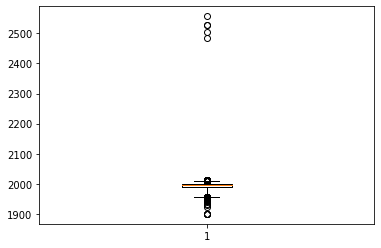

In [52]:
# from the distribution we saw there were outliers in birth_year, let's remove it
box = plt.boxplot(train['onboarding_birth_year'].dropna(),whis = [1, 99])
u = [item.get_ydata()[1] for item in box['whiskers']]


In [53]:
train['onboarding_birth_year'][(train['onboarding_birth_year']<u[0]) | (train['onboarding_birth_year']>u[1])] = None
test['onboarding_birth_year'][(test['onboarding_birth_year']<u[0]) | (test['onboarding_birth_year']>u[1])] = None


<ipython-input-53-1513740f584d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['onboarding_birth_year'][(train['onboarding_birth_year']<u[0]) | (train['onboarding_birth_year']>u[1])] = None
<ipython-input-53-1513740f584d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['onboarding_birth_year'][(test['onboarding_birth_year']<u[0]) | (test['onboarding_birth_year']>u[1])] = None


### Data transformation

In [54]:
# transform timestamps to date format
train['install_timestamp'] = pd.to_datetime(train['install_timestamp']) 
train['free_trial_timestamp'] = pd.to_datetime(train['free_trial_timestamp'])

test['install_timestamp'] = pd.to_datetime(test['install_timestamp']) 
test['free_trial_timestamp'] = pd.to_datetime(test['free_trial_timestamp'])

In [55]:
# group countries with few entries
country_few_obs = (train['country'].value_counts()[(train['country'].value_counts())<30]).index
train['country'][train['country'].isin(country_few_obs)] = 'other'
test['country'][test['country'].isin(country_few_obs)] = 'other'

<ipython-input-55-df4c6611ca11>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['country'][train['country'].isin(country_few_obs)] = 'other'
<ipython-input-55-df4c6611ca11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['country'][test['country'].isin(country_few_obs)] = 'other'


In [56]:
# group language with few entries
language_few_obs = (train['language'].value_counts()[(train['language'].value_counts())<30]).index
train['language'][train['language'].isin(language_few_obs)] = 'other'
test['language'][test['language'].isin(language_few_obs)] = 'other'

<ipython-input-56-65a341714ef3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['language'][train['language'].isin(language_few_obs)] = 'other'
<ipython-input-56-65a341714ef3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['language'][test['language'].isin(language_few_obs)] = 'other'


In [57]:
# group device_type with few entries
device_few_obs = (train['device_type'].value_counts()[(train['device_type'].value_counts())<30]).index
train['device_type'][train['device_type'].isin(device_few_obs)] = 'other'
test['device_type'][test['device_type'].isin(device_few_obs)] = 'other'

<ipython-input-57-9e3c0a76399a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['device_type'][train['device_type'].isin(device_few_obs)] = 'other'
<ipython-input-57-9e3c0a76399a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['device_type'][test['device_type'].isin(device_few_obs)] = 'other'


In [58]:
# divide os_version in 3 colums in order to try to chatch how modern the used device is
train[['os_1','os_2','os_3']] = train.os_version.str.split(".", expand = True)
test[['os_1','os_2','os_3']] = test.os_version.str.split(".", expand = True)
os_few_obs = (train['os_version'].value_counts()[(train['os_version'].value_counts())<30]).index
train['os_version'][train['os_version'].isin(os_few_obs)] = 'other'
test['os_version'][test['os_version'].isin(os_few_obs)] = 'other'

<ipython-input-58-5e29b1422803>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['os_version'][train['os_version'].isin(os_few_obs)] = 'other'
<ipython-input-58-5e29b1422803>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['os_version'][test['os_version'].isin(os_few_obs)] = 'other'


### New features

In [59]:
# try to create new features from given data
train['diff_intall_trial'] = (train['free_trial_timestamp']-train['install_timestamp']).astype('timedelta64[h]') #here I want to check if the time window between installation time and trial time stamp is meaningful
train['age'] = 2023 - train['onboarding_birth_year'] 

test['diff_intall_trial'] = (test['free_trial_timestamp']-test['install_timestamp']).astype('timedelta64[h]') #here I want to check if the time window between installation time and trial time stamp is meaningful
test['age'] = 2023 - test['onboarding_birth_year'] 


### set to 'other' entries in test not seen in train

In [60]:
categorical = ['country','device_type','os_version','onboarding_gender','attribution_network','language','os_1','os_2','os_3']

for col in categorical:
    if (pd.unique(train[col])=='other').sum() == 1:
        test[col][~test[col].isin(pd.unique(train[col]))] = 'other'
    else:
        test[col][~test[col].isin(pd.unique(train[col]))] = 'None'


<ipython-input-60-759514521b0a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][~test[col].isin(pd.unique(train[col]))] = 'other'
<ipython-input-60-759514521b0a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][~test[col].isin(pd.unique(train[col]))] = 'None'


#Model

In [61]:
'''
Here I try see how basic models perform before chosing the one on which perform some parameter tuning 
'''

'\nHere I try see how basic models perform before chosing the one on which perform some parameter tuning \n'

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [63]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [64]:
# I decided to impute the missing data and after some tries a simple random forest for imputing missing data seems what was working best
# here removing missing data was not an option given that we have missing data also in test set. I also tried to simply impute missing 
# with median and most frequent class respectively for numericl and categorical variables. An other method tested is knn imputation, 
# but actually, even though just slightly, random forest imputation sees to perform better

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

categorical = ['country','device_type','os_version','onboarding_gender','attribution_network','language','os_1','os_2','os_3']
numerical = ["net_purchases_15d",'age','product_price_tier','product_periodicity','onboarding_birth_year', 'diff_intall_trial']

for col in categorical:
    lab_enc = LabelEncoder().fit(train[col][train[col].notnull()])
    train[col][train[col].notnull()] = lab_enc.transform(train[col][train[col].notnull()])
    test[col][test[col].notnull()] = lab_enc.transform(test[col][test[col].notnull()])
   

imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                            initial_strategy='mean',
                            max_iter=10, random_state=0)
imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                            initial_strategy='most_frequent',
                            max_iter=10, random_state=0)
imp_num.fit(train[numerical])
imp_cat.fit(train[categorical])


train[numerical] = imp_num.transform(train[numerical])
train[categorical] = imp_cat.transform(train[categorical])

test[numerical] = imp_num.transform(test[numerical])
test[categorical] = imp_cat.transform(test[categorical])


# once I removed the missing value I get the one hot encoding for the categorical variable
ohe = OneHotEncoder(sparse=False)
cat_train = ohe.fit_transform(train[categorical])
cat_train = pd.DataFrame(cat_train,columns = ohe.get_feature_names_out())
train_mod = pd.concat([train[numerical],cat_train],axis=1)
train_mod['boxcox_15d'] = boxcox(train['net_purchases_15d'], 0.5) # I'm adding a transformation fot the net_purchases_15d since it was almost the only feature correlated with the objective vafiable

cat_test = ohe.transform(test[categorical])
cat_test = pd.DataFrame(cat_test,columns = ohe.get_feature_names_out())
test_mod = pd.concat([test[numerical],cat_test],axis=1)
test_mod['boxcox_15d'] = boxcox(test['net_purchases_15d'], 0.5) # I'm adding a transformation fot the net_purchases_15d since it was almost the only feature correlated with the objective vafiable


<ipython-input-64-508c061a358e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col][train[col].notnull()] = lab_enc.transform(train[col][train[col].notnull()])
<ipython-input-64-508c061a358e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][test[col].notnull()] = lab_enc.transform(test[col][test[col].notnull()])
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [90]:
# Actually the one year total purchases include the first 15 days purchases, so I transform the objective to the prediction of the total amount spent after the first 15 days
# another try I made was transforming the objective variable to the number of renewal the client paid before unsubscribing (relatively their product_price_tier and product_periodicity)
# this didn't improved the performance so I quit the tests on that idea. 
# Another try I made was predicting the log transformation of net_purchases_1y hoping that a better shaped distribution would have led to better predictions but it was not the case.

y_train_mod = train['net_purchases_1y']-train['net_purchases_15d']
y_train_mod[y_train_mod<0] = 0

X_train, X_test, y_train, y_test = train_test_split(train_mod, y_train_mod, test_size=0.33, random_state=42)


In [91]:
# Also a normalization step has been tried but it didn't improved model performances

In [92]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(max_depth=2) 
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [93]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')

model_xgb.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror')

In [94]:
model_lm = LinearRegression()
model_lm.fit(X_train, y_train)

LinearRegression()

In [95]:
model_gbt = GradientBoostingRegressor()
model_gbt.fit(X_train, y_train)

GradientBoostingRegressor()

In [96]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train) 

RandomForestRegressor()

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
model.fit(X_train, y_train, epochs=10, batch_size=32)



Epoch 1/10
280/280 [==============================] - 2s 3ms/step - loss: 212.0123 - mse: 212.0123 - mae: 8.0273
Epoch 2/10
280/280 [==============================] - 1s 3ms/step - loss: 192.5201 - mse: 192.5201 - mae: 7.3200
Epoch 3/10
280/280 [==============================] - 1s 3ms/step - loss: 175.9037 - mse: 175.9037 - mae: 6.4327
Epoch 4/10
280/280 [==============================] - 1s 3ms/step - loss: 170.9474 - mse: 170.9474 - mae: 6.2696
Epoch 5/10
280/280 [==============================] - 1s 3ms/step - loss: 171.1096 - mse: 171.1096 - mae: 6.1576
Epoch 6/10
280/280 [==============================] - 1s 4ms/step - loss: 168.8123 - mse: 168.8123 - mae: 6.1337
Epoch 7/10
280/280 [==============================] - 1s 5ms/step - loss: 168.8107 - mse: 168.8107 - mae: 6.1141
Epoch 8/10
280/280 [==============================] - 1s 4ms/step - loss: 168.1759 - mse: 168.1759 - mae: 6.1010
Epoch 9/10
280/280 [==============================] - 1s 3ms/step - loss: 168.5823 - mse: 168.58

In [98]:
y_pred_test_lm = model_lm.predict(X_test)
y_pred = (y_pred_test_lm)
y_pred[(y_pred)<=0]=0

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_lm = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"Linear Regression RMSE: {rmse_lm}") 

# given the error providing the average y_train the model performs not so well, just a small decrease in RMSE

Average RMSE: 13.814690734715173
Linear Regression RMSE: 12.428641843396715


In [99]:
y_pred_test_gbt = model_gbt.predict(X_test)
y_pred_test_gbt[y_pred_test_gbt<0] = 0
y_pred = (y_pred_test_gbt) 

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_gbt = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"GBT RMSE: {rmse_gbt}") 

# gbt has better performance than the linear model but the increase is really small

Average RMSE: 13.814690734715173
GBT RMSE: 12.312720744485876


In [100]:
y_pred_test_gbt = model_xgb.predict(X_test)
y_pred_test_gbt[y_pred_test_gbt<0] = 0
y_pred = (y_pred_test_gbt) 

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_gbt = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"Xgboost RMSE: {rmse_gbt}") 

#xgb has similar performance

Average RMSE: 13.814690734715173
Xgboost RMSE: 12.284007427439883


In [101]:
y_pred_test_rf = model_rf.predict(X_test)
y_pred = (y_pred_test_rf)

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_rf = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"Linear Regression RMSE: {rmse_rf}")

# random forest is the model that perform worst

Average RMSE: 13.814690734715173
Linear Regression RMSE: 13.13745727980981


In [102]:
y_pred_test_nn = model.predict(X_test)
y_pred = (y_pred_test_nn)

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_rf = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"Linear Regression RMSE: {rmse_rf}")

# similar performance with respect to gbt and xgb

138/138 [==============================] - 0s 1ms/step
Average RMSE: 13.814690734715173
Linear Regression RMSE: 12.365722537158412


In [103]:
y_pred_test_dt = model_dt.predict(X_test)
y_pred = (y_pred_test_dt)

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_rf = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"Linear Regression RMSE: {rmse_rf}") 

# angain similar performance. The fact that a simple tree with depth 2 can perform just as more complicated models suggest that here the limit is not really the model 
# doing a step back in order to try to understand better the problem and maybe work on the data could bring more value than work on the model

Average RMSE: 13.814690734715173
Linear Regression RMSE: 12.323616655707916


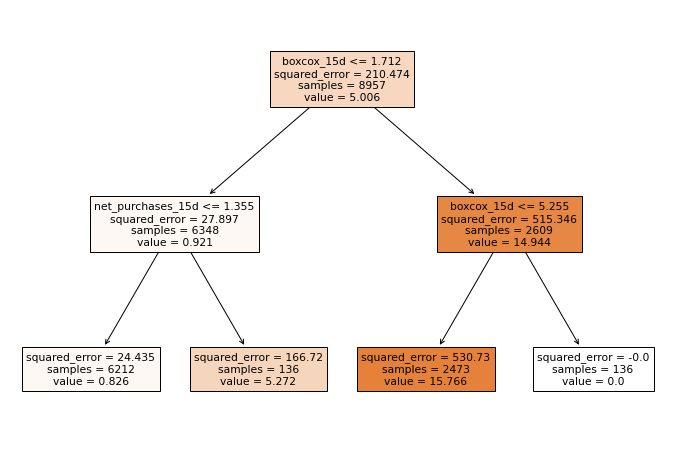

In [104]:

from sklearn import tree
fig = plt.figure(figsize=(12,8))
_ = tree.plot_tree(model_dt, 
                   feature_names=X_test.columns,  
                   filled=True)
# from the tree visualization we can see that, as we guessed before, net_purchases_15d is driving the model decision.
# we can see that the model is quite good in dividing people in high and low spender, on low spender it perform quite well, the problem seems to be in high spender prediction

### Classification

In [105]:
'''
Form previous observations we saw that the model performs better on low spender, the idea here is to divide the problem in two parts:
     - predict who is going to spend something in the year (excluding the first 15 days) and who is not
     - predict the amount spent by people classified as spender
'''

'\nForm previous observations we saw that the model performs better on low spender, the idea here is to divide the problem in two parts:\n     - predict who is going to spend something in the year (excluding the first 15 days) and who is not\n     - predict the amount spent by people classified as spender\n'

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_class = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train>0)
scores = gbt_class.score(X_test, y_test>0)
scores

0.8683435304781328

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

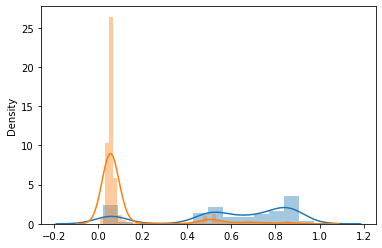

In [107]:
prob = gbt_class.predict_proba(X_test)
class_gbt = gbt_class.predict(X_test)
sns.distplot(prob[:,1][y_test>0])
sns.distplot(prob[:,1][y_test<=0])

# The classification seems to be quite good, the distribution below show that the model is able to predict high probability for people that are actually spender and low probability for non spender. also the over all accuracy seems good

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


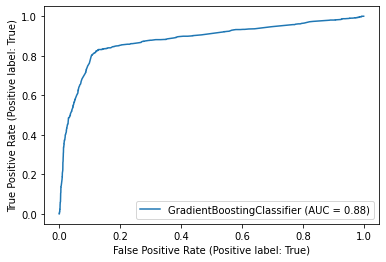

In [108]:
from sklearn import metrics

metrics.plot_roc_curve(gbt_class, X_test, y_test>0) 
# quite high auc and from the shape there could be a group on which the model perform better, from tree above we gould guess it's related to the value of net purchase 15d, maybe something like the first rule of the plotted tree

In [109]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 36.8 MB/s eta 0:00:00


In [110]:
import shap

explainer = shap.TreeExplainer(gbt_class)
shap_values = explainer.shap_values(X_test)

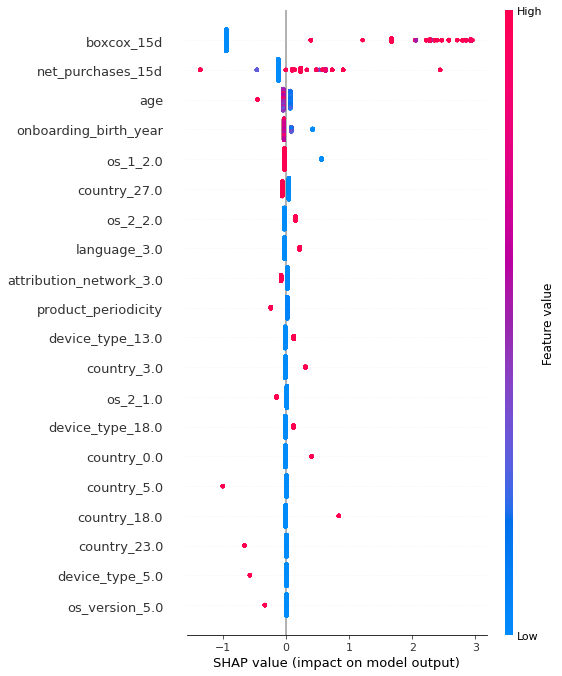

In [111]:
shap.summary_plot(shap_values, X_test)

# The shap plot suggest that the net_purchases transformation is the most important variable for the classification, and the direction is the same we could guess, 
# low value brings to non spender, while high value brings to high spender, actually the other feature doesn't seem to be very important or having a clear direction.

In [112]:
# for the second model to stack on the classification I train on the predicted spender
avg_train_prob = (y_train>0).mean()
prob = gbt_class.predict_proba(X_train)
is_spender = prob[:,1]>avg_train_prob


model_gbt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error')
model_gbt.fit(X_train[is_spender], (y_train[is_spender]))

model_dt = DecisionTreeRegressor(max_depth=2)
model_dt.fit(X_train[is_spender], (y_train[is_spender]))

DecisionTreeRegressor(max_depth=2)

In [113]:
# here I compare the predicted probability with the ratio of spender in train set. usually one would take prediction cutting on 0.5 on the predicted probability
# but here I don't have a balanced dataset, so I will consider spender who has a predicted probability higher than the spender ratio on train set
avg_train_prob = (y_train>0).mean()
prob = gbt_class.predict_proba(X_test)
is_spender = prob[:,1]>avg_train_prob


In [114]:
y_pred_test_gbt = model_gbt.predict(X_test[is_spender])
y_pred = np.repeat(0,X_test.shape[0])
y_pred[is_spender] = (y_pred_test_gbt)

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_gbt = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"2 step gbt RMSE: {rmse_gbt}") 

# the 2 step gbt doesn't seems to have improved performances overall

Average RMSE: 13.814690734715173
2 step gbt RMSE: 12.330042160572637


In [115]:
y_pred_test_gbt = model_dt.predict(X_test[is_spender])
y_pred = np.repeat(0,X_test.shape[0])
y_pred[is_spender] = (y_pred_test_gbt)

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_gbt_spender = rmse(y_test[is_spender], y_pred[is_spender])
rmse_gbt_nonspender = rmse(y_test[~is_spender], y_pred[~is_spender])

print(f"Average RMSE: {rmse_avg}")
print(f"2 step gbt RMSE - spender: {rmse_gbt_spender}") 
print(f"2 step gbt RMSE - non spender: {rmse_gbt_nonspender}") 

# if we split the error we see that we have a much higher error on spender population

Average RMSE: 13.814690734715173
2 step gbt RMSE - spender: 21.392571912800914
2 step gbt RMSE - non spender: 5.459760171154555


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

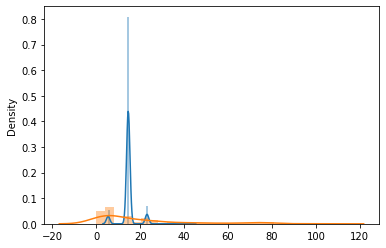

In [116]:
sns.distplot(y_pred_test_gbt)
sns.distplot((y_test[y_test>0]))
# the model doesn't seems to be able to catch the variability of the objective

### Lasso selection

In [117]:
# in order to generalize better I'm going to select feature using lasso regression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...............model__alpha=0.1;, score=-177.014 total time=   0.2s
[CV 2/5] END ...............model__alpha=0.1;, score=-180.784 total time=   0.2s
[CV 3/5] END ...............model__alpha=0.1;, score=-151.807 total time=   0.2s
[CV 4/5] END ...............model__alpha=0.1;, score=-144.024 total time=   0.2s
[CV 5/5] END ...............model__alpha=0.1;, score=-185.298 total time=   0.2s
[CV 1/5] END ...............model__alpha=0.2;, score=-178.462 total time=   0.2s
[CV 2/5] END ...............model__alpha=0.2;, score=-182.222 total time=   0.2s
[CV 3/5] END ...............model__alpha=0.2;, score=-152.608 total time=   0.2s
[CV 4/5] END ...............model__alpha=0.2;, score=-144.869 total time=   0.2s
[CV 5/5] END ...............model__alpha=0.2;, score=-187.871 total time=   0.2s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-181.016 total time=   0.1s
[CV 2/5] END model__alpha=0.30000000000000004;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [118]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)


In [119]:
(importance!=0).sum()/len(importance) # we are going to keep half of the original variables

0.5436893203883495

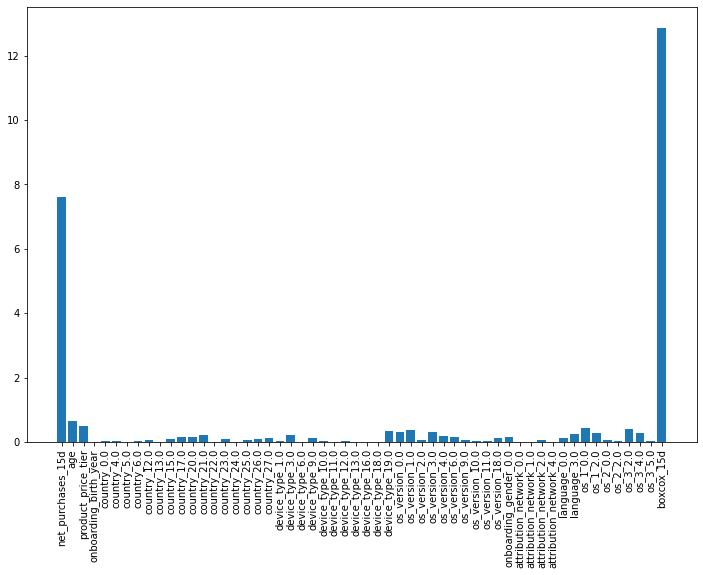

In [120]:
plt.figure(figsize=(12,8))
plt.bar(np.arange((importance!=0).sum()),importance[importance!=0])
plt.xticks(np.arange((importance!=0).sum()), list(X_train.columns[importance!=0]), rotation = 90)
plt.show()

In [123]:
model_gbt = GradientBoostingRegressor()
model_gbt.fit(X_train[X_train.columns[importance!=0]], y_train ) 

GradientBoostingRegressor()

In [124]:
y_pred_test_gbt = model_gbt.predict(X_test[X_train.columns[importance!=0]])
y_pred_test_gbt[y_pred_test_gbt<0] = 0
y_pred = (y_pred_test_gbt)

rmse_avg = rmse(y_test, np.repeat(np.mean(y_train), len(y_test)))
rmse_gbt = rmse(y_test, y_pred)

print(f"Average RMSE: {rmse_avg}")
print(f"Linear Regression RMSE: {rmse_gbt}") 

# the selection is has not improved performance but having less variable could bring to better generalization, so I will stick with the reduced number of features

Average RMSE: 13.814690734715173
Linear Regression RMSE: 12.310673496695749


### Parameter tuning

In [146]:
# let's check if with some parameter tuning we can slightly improve performancies
pipeline = Pipeline([
                     ('model',xgb.XGBRegressor(objective ='reg:squarederror'))
])

search = GridSearchCV(pipeline,
                      {'model__eta':np.arange(0.05,0.3,0.025),
                       'model__subsample':np.arange(0.5,1,0.1),
                       'model__max_depth':[2,4,5,6]
                       },
                      cv = 3, scoring="neg_mean_squared_error",verbose=1
                      )

search.fit(X_train[X_train.columns[importance!=0]], y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(objective='reg:squarederror'))]),
             param_grid={'model__eta': array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 ,
       0.275]),
                         'model__max_depth': [2, 4, 5, 6],
                         'model__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='neg_mean_squared_error', verbose=1)

In [175]:
mod = search.best_estimator_
print('best params: {}'.format(search.best_params_))
y_pred_test_gbt = mod.predict(X_test[X_train.columns[importance!=0]])
y_pred_test_gbt[y_pred_test_gbt<0] = 0
y_pred = (y_pred_test_gbt)

rmse_avg = rmse(y_test.reset_index(drop=True)+(X_test['net_purchases_15d']).reset_index(drop=True), np.repeat(np.mean(y_train+(X_test['net_purchases_15d']).reset_index(drop=True)), len(y_test)))
rmse_gbt = rmse(y_test.reset_index(drop=True)+(X_test['net_purchases_15d']).reset_index(drop=True), y_pred+(X_test['net_purchases_15d']).reset_index(drop=True))

print(f"Average RMSE: {rmse_avg}")
print(f"Linear Regression RMSE: {rmse_gbt}") 

# the model seems to improve just a bit, but I'm still going to use this parameters

best params: {'model__eta': 0.05, 'model__max_depth': 2, 'model__subsample': 0.7999999999999999}
Average RMSE: 15.433552717530958
Linear Regression RMSE: 12.275128627426533


### Predict on test


In [152]:
# retrain on whole train dataset using the best parameters
whole_xgb = xgb.XGBRegressor(objective ='reg:squarederror', eta=0.05, max_depth= 2, subsample= 0.8)

whole_xgb.fit(train_mod[train_mod.columns[importance!=0]], y_train_mod ) 

XGBRegressor(eta=0.05, max_depth=2, objective='reg:squarederror', subsample=0.8)

In [155]:
# predict and return to original objective variable
final_prediction = whole_xgb.predict(test_mod[X_train.columns[importance!=0]])+test_mod['net_purchases_15d']

In [187]:
final_prediction.name = 'y_pred_test'

In [189]:
pd.DataFrame(final_prediction).to_csv('submission.csv', index=False)

# Recap

In order to solve the proposed problem I tried first of all to undestand better the data in order to build a model able to predict the one year net purchases of a client.

The main take aways from the first exploratory analysis are that the objective variable is skewed on the right and in general there is a great number of client purchasing 0 in a year.
There is no independent variable highly correlated with the objective variable.
There are some missing data and some wrongly imputated data.
The test set seems to have the same distribution with respect to the train set.

Then the second step was to remove the clear outliers in the date of birth. Other thecnique of outlier detection were tried but they didn't seem to increase performance. Here the distribution of the y and the evaluation method bring lot of attention to the small part of high spender, here removing multi dimension outlier could be dangerous. Instead of removing outliers I decided to group rare occurencies in some features in order to try to preserve the original information as much as possible.

The third step was to impute the data for which I built two random forests. 

Than I tried some models in order to asses which model was worth to deep dive.
From the different runs I got that the type of model doesn't change much.

I decided to try to split the problem into 2 parts. The result was that understanding who is a spender and who is not it's something pretty easy, but predicting the total purchase seems to be quite hard.

To refine the model I selected some relevant features and performed parameter tuning; but as previously said the model in this problem seems to matter relatively. Probably having some other feature more related with the total purchase would help.
For example having something related to usage I think would increase the model performance.



